# Project 1: Resolving the sources of gas ionisation in galaxies using optical spectroscopy. #


### Import Recquired Packages ###

In [1]:
from astropy.io import fits
from matplotlib import pyplot as plt
import numpy as np
from astropy.convolution import convolve, convolve_fft, Gaussian1DKernel
from scipy import interpolate	


### Read in fits files ###

In [2]:
blue = fits.open('/home/jovyan/ASTR7913/Project1/data/9016800074_A_adaptive_blue.fits.gz')
red = fits.open('/home/jovyan/ASTR7913/Project1/data/9016800074_A_adaptive_red.fits.gz')

In [3]:
blue.info()
red.info()

Filename: /home/jovyan/ASTR7913/Project1/data/9016800074_A_adaptive_blue.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      84   (50, 50, 2048)   float64   
  1  VARIANCE      1 ImageHDU         9   (50, 50, 2048)   float64   
  2  BIN_MASK      1 ImageHDU         8   (50, 50)   float64   
  3  QC            1 BinTableHDU     33   8R x 12C   [20A, E, E, E, E, E, E, E, E, E, E, E]   
  4  DUST          1 ImageHDU         9   (2048,)   float64   
Filename: /home/jovyan/ASTR7913/Project1/data/9016800074_A_adaptive_red.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      84   (50, 50, 2048)   float64   
  1  VARIANCE      1 ImageHDU         9   (50, 50, 2048)   float64   
  2  BIN_MASK      1 ImageHDU         8   (50, 50)   float64   
  3  QC            1 BinTableHDU     33   8R x 12C   [20A, E, E, E, E, E, E, E, E, E, E, E]   
  4  DUST          1 ImageHDU         9   (2048,)   fl

In [4]:
blue[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                   50                                                  
NAXIS2  =                   50                                                  
NAXIS3  =                 2048                                                  
EXTEND  =                    T                                                  
WCSAXES =                    3 / Number of coordinate axes                      
CRPIX1  =                 25.5 / Pixel coordinate of reference point            
CRPIX2  =                 25.5 / Pixel coordinate of reference point            
CRPIX3  =               1024.0 / Pixel coordinate of reference point            
CDELT1  = -0.00013888888888889 / [deg] Coordinate increment at reference point  
CDELT2  =  0.000138888888888

### Generate a wavelength vector from the header information ###

In [5]:
def SAMI_WAVE(header):
    CDELT=header['CDELT3']
    CRVAL=header['CRVAL3']
    CRPIX=header['CRPIX3']
    npix=header['NAXIS3']
    x=CRVAL+CDELT*(np.arange(npix)+1-CRPIX)
    return x

In [6]:
x_b=SAMI_WAVE(blue[0].header)
x_r=SAMI_WAVE(red[0].header)

### Plot Flux vs Wavelength ###

In [7]:
#make a tag to call specific PRIMARY flux 
bluespec=blue[0].data
bluevar=blue[1].data
redspec=red[0].data
redvar=red[1].data

In [8]:
# Check length is 2048
bluespec[:,24,24].shape

(2048,)

Text(0, 0.5, 'Flux(/1e-16 erg/cm$^2$/s/Angstrom')

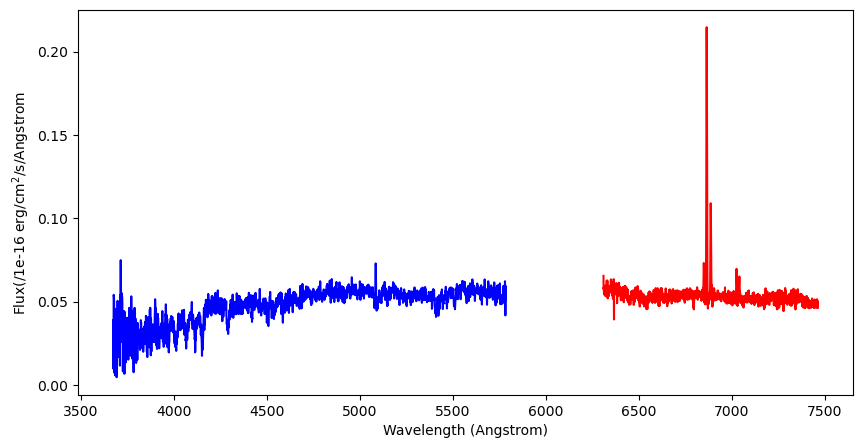

In [9]:
#plot both the blue and red spectra on the same graph
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(SAMI_WAVE(blue[0].header), bluespec[:,24,24], 'blue')
plt.plot(SAMI_WAVE(red[0].header), redspec[:,24,24], 'red')
#plot labels
plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Flux(/1e-16 erg/cm$^2$/s/Angstrom')

In [10]:
## GET plt.imshow() to work here

### Correcting spectra for foreground extinction due to dust ###

In [50]:
#DUST_CORR is a function that corrects the individual blue or red spectra for a single pixel
def DUST_CORR(colour, pixel):
    test = pixel*(colour[4].data)
    return test
    

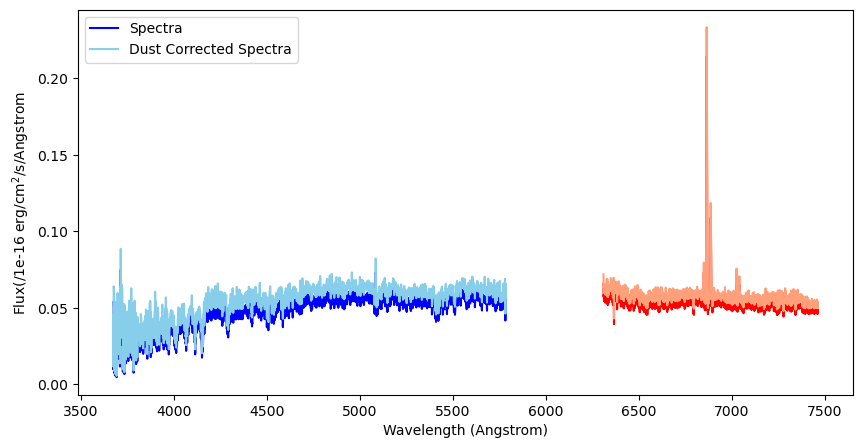

In [51]:
#Here we plot the original test pixel spectra against the newly dust corrected spectra for the same pixel. 
#Lighter colours show the dust corrected spectra.
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(SAMI_WAVE(blue[0].header), bluespec[:,24,24], 'blue', label='Spectra')
plt.plot(SAMI_WAVE(blue[0].header), DUST_CORR(blue,bluespec[:,24,24]), 'skyblue', label='Dust Corrected Spectra')
plt.plot(SAMI_WAVE(red[0].header), redspec[:,24,24], 'red')
plt.plot(SAMI_WAVE(red[0].header), DUST_CORR(red,redspec[:,24,24]), 'lightsalmon')


plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Flux(/1e-16 erg/cm$^2$/s/Angstrom')
plt.legend()

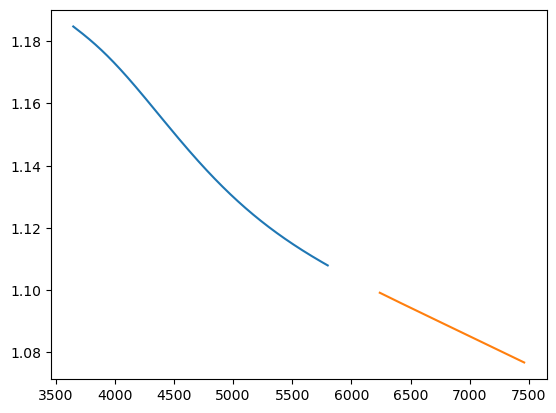

In [52]:
plt.plot(SAMI_WAVE(blue[0].header), blue[4].data)
plt.plot(SAMI_WAVE(red[0].header), red[4].data)

In [53]:
dcorr_b=DUST_CORR(blue,bluespec[:,24,24])
dcorr_r=DUST_CORR(red,redspec[:,24,24])

### Find the quadrature difference between blue and red arm instrumental resolutions ###

 $\sqrt{FWHM_{blue}^2 - FWHM_{red}^2}$

In [54]:
#Blue-arm FWHM is 2.66 Angstrom
#Red-arm FWHM is 1.59 Angstrom
dFWHM=np.sqrt((2.66**2)-(1.59**2))
dFWHM

2.1324868112136124

### Convolve red arm flux and variance ###

In [55]:
#first we define the standard deviation so we can feed it into our kernel 
sd=dFWHM/2.355
sdpix=sd/red[0].header['CDELT3']
print(sd, sdpix)

0.9055145695174575 1.519334691641124


In [56]:
#define our gaussian kernel 
gauss = Gaussian1DKernel(sdpix)
gauss.array


array([1.07837940e-04, 1.16824163e-03, 8.20645123e-03, 3.73800369e-02,
       1.10404221e-01, 2.11442970e-01, 2.62580482e-01, 2.11442970e-01,
       1.10404221e-01, 3.73800369e-02, 8.20645123e-03, 1.16824163e-03,
       1.07837940e-04])

In [57]:
r_smooth= convolve(redspec[:,24,24], gauss.array)
rvar_smooth= convolve(redvar[:,24,24], gauss.array)

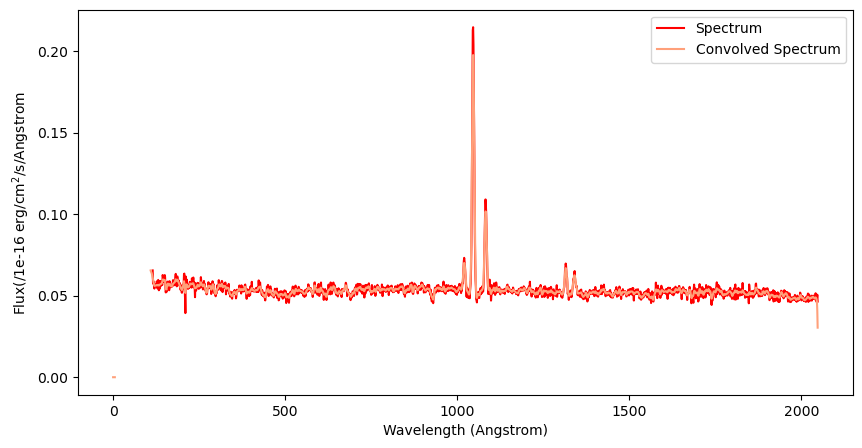

In [58]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(redspec[:,24,24], 'red', label='Spectrum')
plt.plot(r_smooth, 'lightsalmon', label='Convolved Spectrum')


plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Flux(/1e-16 erg/cm$^2$/s/Angstrom')
plt.legend()

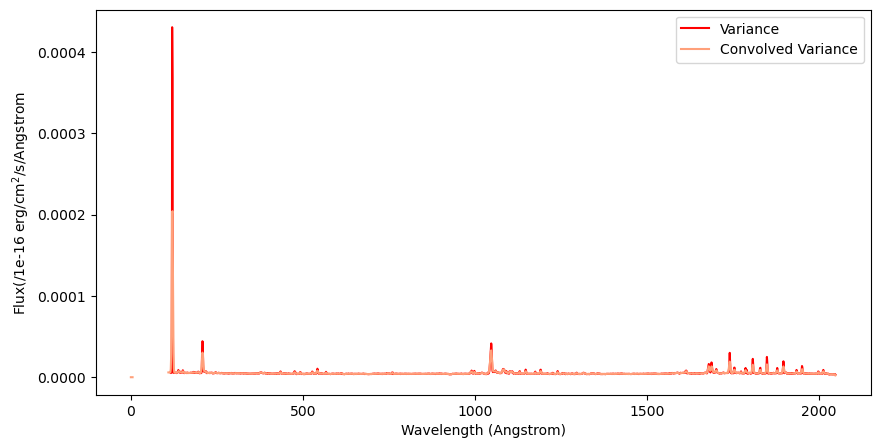

In [59]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(redvar[:,24,24], 'red', label='Variance')
plt.plot(rvar_smooth, 'lightsalmon', label='Convolved Variance')


plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Flux(/1e-16 erg/cm$^2$/s/Angstrom')
plt.legend()

### Create a wavelength vector of blue arm pixel size ###

SAMI_WAVE above can be used for the blue arm and red arm seperately but this needs to be adapted for the red to give blue pixel size over these wavelengths.

In [60]:
x_comb=np.arange(3650, 7800, blue[0].header['CDELT3'])

In [61]:
#Lengthy approach 
# def SAMI_BLUE_WAVE(header, header2):
#     CDELT=header['CDELT3']
#     CRVAL=header['CRVAL3']
#     CRPIX=header['CRPIX3']
#     npix=header['NAXIS3']
#     x=CRVAL+CDELT*(np.arange(npix)+1-CRPIX)
#     CRVAL2=header2['CRVAL3']
#     CRPIX2=header2['CRPIX3']
#     npix2=header2['NAXIS3']
#     x2=CRVAL2+CDELT*(np.arange(npix2)+1-CRPIX2)
#     return x, x2
    
# SAMI_BLUE_WAVE(blue[0].header, red[0].header)

### Interpolate red flux and variance ###

#### red flux ####

In [62]:
#Set up a flag to find the NaNs:
NaNFlag=np.isnan(r_smooth)
#set up the interpolator using the original x_r and the smoothed flux. Note the “bounds_error” needs to be “False” so that any bad
#values get set to the “fill_value” (1e10 here). Note the ‘~’ to #reverse the NaNFlag boolean array and include only non-Nan pixels:
interp=interpolate.interp1d(x_r[~NaNFlag],r_smooth[~NaNFlag],kind='cubic',bounds_error=False,fill_value=1e10)	
#do the interpolation
r_interp=interp(x_comb)


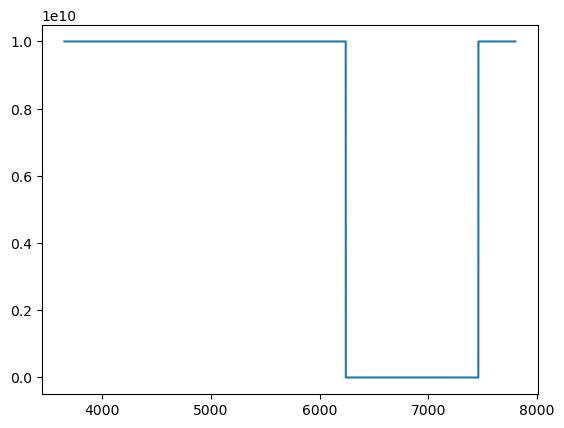

In [63]:
plt.plot(x_comb, r_interp)

In [64]:
#copy into a more appropriately named vector
BR_interp=r_interp.copy()
#fill in the blue part
BR_interp[x_comb < np.max(x_b)]=bluespec[:,24,24]


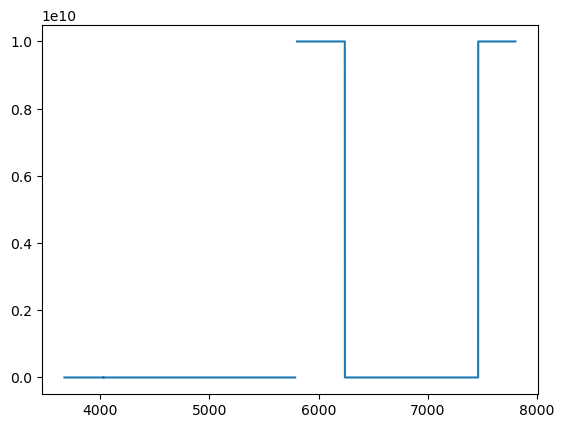

In [65]:
plt.plot(x_comb, BR_interp)

#### Variance ####

In [66]:
#Set up a flag to find the NaNs:
NaNFlag=np.isnan(rvar_smooth)
#set up the interpolator using the original 
var_interp=interpolate.interp1d(x_r[~NaNFlag],rvar_smooth[~NaNFlag],kind='cubic',bounds_error=False,fill_value=1e10)	
#do the interpolation
rvar_interp=var_interp(x_comb)

BRvar_interp=rvar_interp.copy()
#fill in the blue part
BRvar_interp[x_comb < np.max(x_b)]=bluevar[:,24,24]

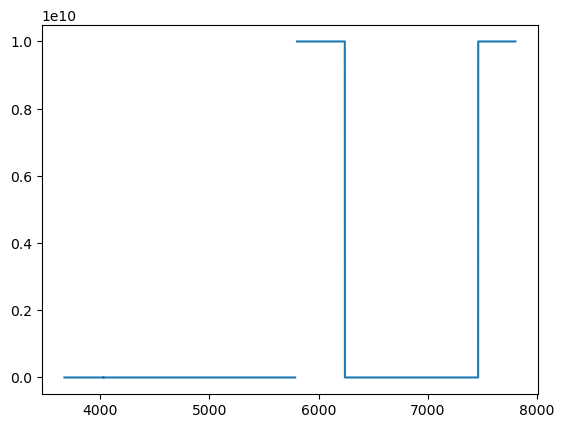

In [67]:
plt.plot(x_comb, BRvar_interp)

### Replace flux free regions and region extremes with nans ###

In [68]:
BR_interp= np.where(BR_interp==1.00000000e+10, np.nan, BR_interp)
BRvar_interp= np.where(BRvar_interp==1.00000000e+10, np.nan, BRvar_interp)

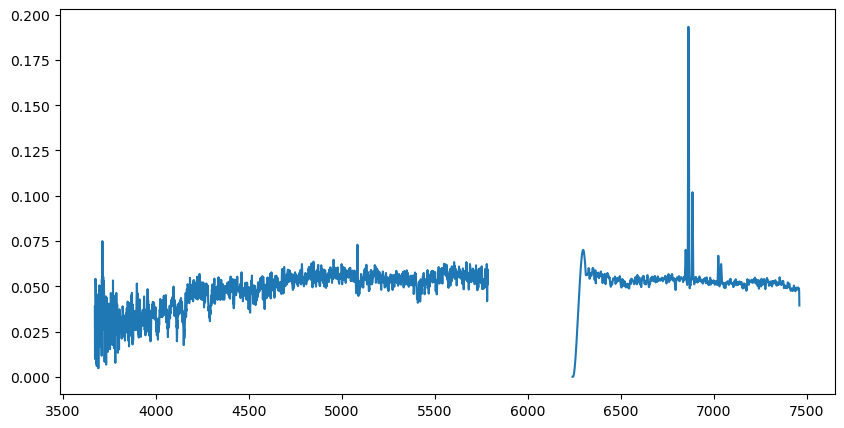

In [69]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(x_comb, BR_interp)

In [70]:
r_end=3627
b_start=21
b_end=2032
r_start=2466

In [71]:
BR_interp[2466:2476]

array([-3.32443469e-08,  2.51255544e-08,  6.52026588e-07,  1.06923602e-05,
        1.49580138e-04,  4.36437355e-04,  8.65229086e-04,  1.42992041e-03,
        2.12447639e-03,  2.94286212e-03])

In [72]:
number = 1

while number <= 10:
    #print(BR_interp[(b_start-1)+number], BR_interp[(b_end+1)-number],BR_interp[(r_end+1)-number])
    BR_interp=np.where(BR_interp==BR_interp[(b_start-1)+number], np.nan, BR_interp)
    BR_interp=np.where(BR_interp==BR_interp[(b_end+1)-number], np.nan, BR_interp)
    BR_interp=np.where(BR_interp==BR_interp[(r_end+1)-number], np.nan, BR_interp)
    BRvar_interp=np.where(BRvar_interp==BRvar_interp[(b_start-1)+number], np.nan, BRvar_interp)
    BRvar_interp=np.where(BRvar_interp==BRvar_interp[(b_end+1)-number], np.nan, BRvar_interp)
    BRvar_interp=np.where(BRvar_interp==BRvar_interp[(r_end+1)-number], np.nan, BRvar_interp)
    #print(BR_interp[(b_start-1)+number], BR_interp[(b_end+1)-number],BR_interp[(r_end+1)-number])
    number = number + 1

In [73]:
number = 1

while number <= 65:
    #print(BR_interp[(r_start-1)+number])
    BR_interp=np.where(BR_interp==BR_interp[(r_start-1)+number], np.nan, BR_interp)
    BRvar_interp=np.where(BRvar_interp==BRvar_interp[(r_start-1)+number], np.nan, BRvar_interp)
    #print(BR_interp[(r_start-1)+number])
    number = number + 1

In [74]:
#with np.printoptions(threshold=np.inf):
   # print(BR_interp)

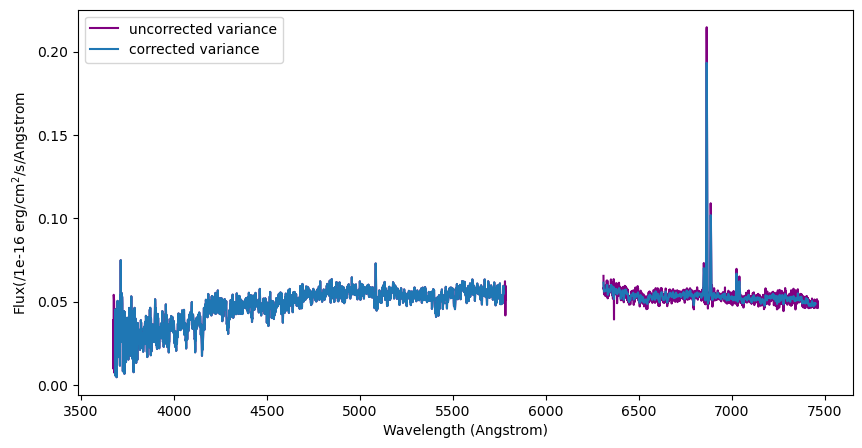

In [75]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(SAMI_WAVE(red[0].header), redspec[:,24,24], 'purple', label='uncorrected variance')
plt.plot(SAMI_WAVE(blue[0].header), bluespec[:,24,24], 'purple')
plt.plot(x_comb, BR_interp, label='corrected variance')
plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Flux(/1e-16 erg/cm$^2$/s/Angstrom')
plt.legend()

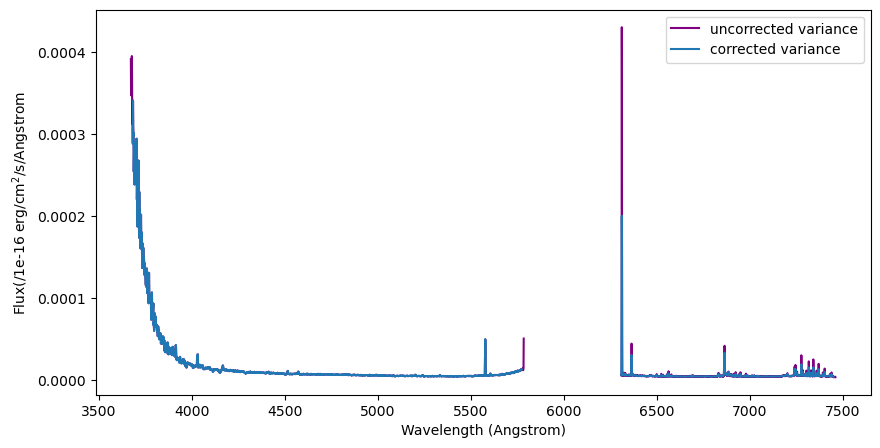

In [76]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(SAMI_WAVE(red[0].header), redvar[:,24,24], 'purple', label='uncorrected variance')
plt.plot(SAMI_WAVE(blue[0].header), bluevar[:,24,24], 'purple')
plt.plot(x_comb, BRvar_interp, label='corrected variance')
plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Flux(/1e-16 erg/cm$^2$/s/Angstrom')
plt.legend()

## Creating a full function ##

In [101]:
def Spectra(x,y): 
    #correct for the dust using the DUST fucntion defined above. 
    dcorr_b=DUST_CORR(blue,bluespec[:, x, y])
    dcorr_bvar=bluevar[:,x,y]
    dcorr_r=DUST_CORR(red,redspec[:,x,y])
    dcorr_rvar=DUST_CORR(red, redvar[:,x,y])

    #internal derivation of FWHM
    dFWHM=np.sqrt((2.66**2)-(1.59**2))
    sd=dFWHM/2.355
    sdpix=sd/red[0].header['CDELT3'] #this is to convert pixels to angstroms

    #print('check1')

    #Convolve the red arm and red variance
    gauss = Gaussian1DKernel(sdpix) #using scipys inbuilt !D interpolator
    gauss.array
    r_smooth= convolve(dcorr_r, gauss.array) #red arm convolve
    rvar_smooth= convolve(dcorr_rvar, gauss.array) #red arm variance convolve

    #Wavelength vector at blue pixel step size
    x_comb=np.arange(3650, 7800, blue[0].header['CDELT3'])

    print('check2')

    #interpolating the red arm arm and red variance and 
    #Set up a flag to find the NaNs:
    NaNFlag=np.isnan(r_smooth)
    NaNFlag=np.isnan(rvar_smooth)
    #set up the interpolator using the original x_r and the smoothed flux. Note the “bounds_error” needs to be “False” so that any bad
    #values get set to the “fill_value” (1e10 here). Note the ‘~’ to #reverse the NaNFlag boolean array and include only non-Nan pixels:
    interp=interpolate.interp1d(x_r[~NaNFlag],r_smooth[~NaNFlag],kind='cubic',bounds_error=False,fill_value=1e10)	
    var_interp=interpolate.interp1d(x_r[~NaNFlag],rvar_smooth[~NaNFlag],kind='cubic',bounds_error=False,fill_value=1e10)	
    #do the interpolation
    r_interp=interp(x_comb)
    rvar_interp=var_interp(x_comb)

    #add the blue arms to interpolated 
    BR_interp=r_interp.copy()
    BRvar_interp=rvar_interp.copy()
    #fill in the blue part
    BR_interp[x_comb < np.max(x_b)]=dcorr_b
    BRvar_interp[x_comb < np.max(x_b)]=dcorr_bvar


    print('check3')

    #removing the bad values for 
    BR_interp= np.where(BR_interp==1.00000000e+10, np.nan, BR_interp)
    BRvar_interp= np.where(BRvar_interp==1.00000000e+10, np.nan, BRvar_interp)

    #edge of the spectrum indices
    r_end=3627
    b_start=21
    b_end=2032
    r_start=2466

    number = 1
    
    #remove 10 values from the edge of the spectrum except for the start of the red arm which recquired more.
    #use wavelength vector and where this vector is within the first 20 Anngstrom
    while number <= 20:
        #print(BR_interp[(b_start-1)+number], BR_interp[(b_end+1)-number],BR_interp[(r_end+1)-number])
        BR_interp=np.where(BR_interp==BR_interp[(b_start-1)+number], np.nan, BR_interp)
        BR_interp=np.where(BR_interp==BR_interp[(b_end+1)-number], np.nan, BR_interp)
        BR_interp=np.where(BR_interp==BR_interp[(r_end+1)-number], np.nan, BR_interp)
        BRvar_interp=np.where(BRvar_interp==BRvar_interp[(b_start-1)+number], np.nan, BRvar_interp)
        BRvar_interp=np.where(BRvar_interp==BRvar_interp[(b_end+1)-number], np.nan, BRvar_interp)
        BRvar_interp=np.where(BRvar_interp==BRvar_interp[(r_end+1)-number], np.nan, BRvar_interp)
        #print(BR_interp[(b_start-1)+number], BR_interp[(b_end+1)-number],BR_interp[(r_end+1)-number])
        number = number + 1

    number = 1

    #remove edge values from the start of the red arm
    while number <= 65:
        #print(BR_interp[(r_start-1)+number])
        BR_interp=np.where(BR_interp==BR_interp[(r_start-1)+number], np.nan, BR_interp)
        BRvar_interp=np.where(BRvar_interp==BRvar_interp[(r_start-1)+number], np.nan, BRvar_interp)
        #print(BR_interp[(r_start-1)+number])
        number = number + 1

    #plot values to see if it worked
    fig, ax = plt.subplots(figsize=(10, 5))
    plt.plot(SAMI_WAVE(red[0].header), redspec[:,x,y], 'purple', label='uncorrected Spectra')
    plt.plot(SAMI_WAVE(blue[0].header), bluespec[:,x,y], 'purple')
    plt.plot(x_comb, BR_interp, label='corrected Spectra')
    plt.xlabel('Wavelength (Angstrom)')
    plt.ylabel('Flux(/1e-16 erg/cm$^2$/s/Angstrom')
    plt.legend()

return BR_interp, BRvar_interp

    

SyntaxError: 'return' outside function (43815548.py, line 92)

check2
check3


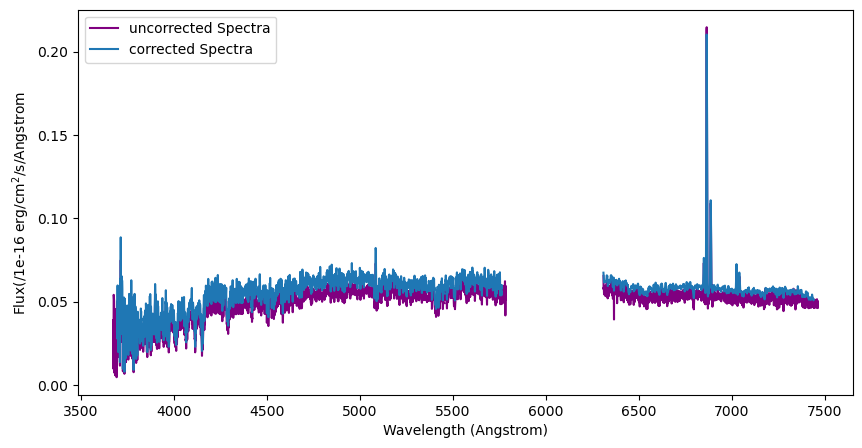

In [84]:
Spectra(24,24)

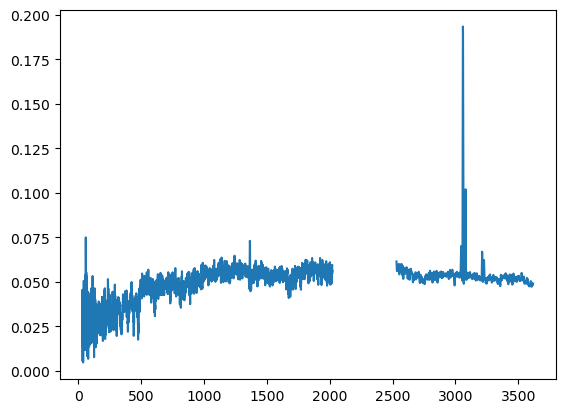

In [103]:
BR_spec=BR_interp
BRvar_spec=BRvar_interp
plt.plot(BR)

# Part 2: pPXF

## Install pPXF

In [79]:
!pip install ppxf

  Obtaining dependency information for ppxf from https://files.pythonhosted.org/packages/7a/f4/cf45d2c6c079e43dec9924636db92bd9d17c31bdbba13c022bae37b386f7/ppxf-9.3.0-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.6/112.6 kB 2.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 5.6 MB/s eta 0:00:0000:01:00:01


In [115]:
import ppxf as ppxf_package
import ppxf.ppxf_util as util
from urllib import request
import ppxf.sps_util as lib
import scipy.constants as const

## Deredshift the wavelength

In [91]:
z=blue[0].header['Z_SPEC']
x_rest=x_comb/(1+z)

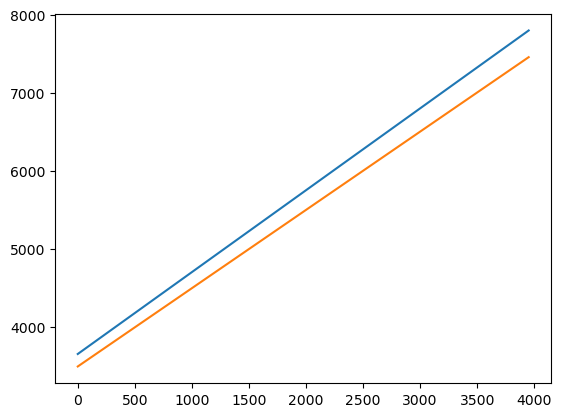

In [93]:
plt.plot(x_comb)
plt.plot(x_rest)

## Rebin data with constant pixel size in velocity space

In [119]:
pix_size=blue[0].header['CDELT3']
lam_range_gal=[np.min(x_rest), np.max(x_rest)]
velscale=np.median(pix_size*const.c/x_rest/1000.)
spec_Lrebin, LogLam, velscale=util.log_rebin(lam_range_gal, BR_spec, velscale=velscale, flux=False)
var_Lrebin, var_LogLam, velscale=util.log_rebin(lam_range_gal, BRvar_spec, velscale=velscale, flux=False)

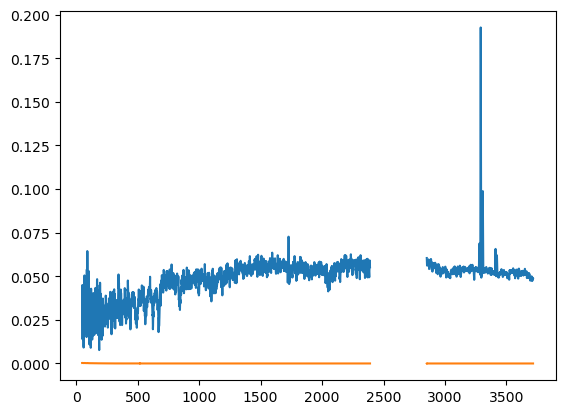

In [126]:
plt.plot(spec_Lrebin)
plt.plot(var_Lrebin)

## Normalise the spectrum and variance

In [145]:
median=np.nanmedian(spec_Lrebin)

In [147]:
normspec=spec_Lrebin/median

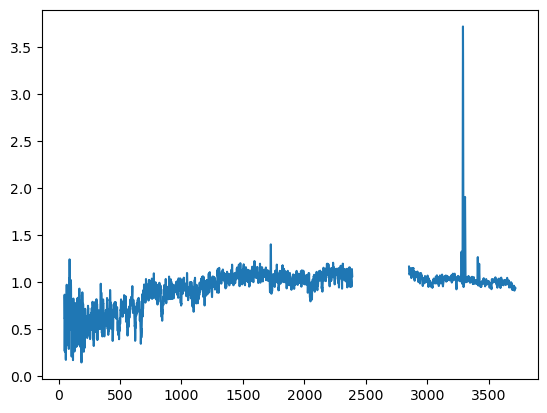

In [149]:
plt.plot(normspec)